@author: Valentin Larrieu

# Linear Regression - PCA - Feature selection - Regularisation

In [57]:
%matplotlib inline 
# notebook
import math                         
import numpy as np      
from sklearn import linear_model   
import random
import string
import time
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.feature_selection as fs
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
seed = 1 # we fix the seed to have the same results for each executions

<img src="https://media.giphy.com/media/VoqAYPOfwr7eU/giphy.gif">
<p style="text-align: center"><strong>What have you done to the data ?</strong></p>

We are working on the python diabetes database. The initial base is <strong>n 442
patients</strong> and <strong>p 10 covariates</strong>. The variable Y to be explained is a score corresponding to the evolution of the
illness. For fun, a malicious robot contaminated the dataset by y <strong>adding 200 variables</strong>
inappropriate explanations. Then, not happy to have already perverted our dataset, he voluntarily
mixed the variables together randomly. Of course the robot then took care of
to erase any trace of his villainous act so that we do not know the relevant variables.
The new database contains <strong>n 442 patients</strong> and <strong>p 210 covariates</strong>, marked X. 

## Importing the data

We import the database

In [3]:
# Detect and count lines with missing values.
na_values = ['?', '']

# We import the dataframe
df = pd.read_csv("https://bitbucket.org/***/data_dm3.csv", sep=',',
                 na_values=na_values, header=None) # We only have data so no header
#Data unavailable

In [4]:
# We print the dataframe to see what he looks like
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0
5,1.513286,0.072830,1.243039,-0.368609,-0.564998,-1.736720,-0.441544,-1.395122,-1.550146,0.941235,...,0.767162,0.417754,-1.010548,1.397951,0.074975,1.381528,-1.367316,1.200057,-0.292088,97.0
6,-0.501760,0.191544,-0.225878,-0.240506,1.350852,-1.253936,1.319458,2.007870,0.423578,0.417597,...,0.382681,-0.146417,-0.529950,-0.568923,0.340738,-1.312723,-0.366522,-0.347242,1.055200,138.0
7,-1.012528,-1.383290,0.686803,2.146420,1.255864,0.806962,0.137307,0.699977,-1.311624,-0.999770,...,-0.444868,-1.175901,0.481975,-0.329621,-1.712838,-0.047186,0.039768,-0.403074,0.249330,63.0
8,0.532639,1.691226,-0.008375,-1.478906,1.278352,-0.176214,-0.806066,0.515730,0.786887,-0.984347,...,0.183080,-0.194879,0.669917,-1.899072,0.122637,0.959231,-0.078359,-0.117192,1.664998,110.0
9,-0.537216,-0.128677,-0.815059,-1.273897,-0.985841,1.021629,-0.956690,1.009193,-0.030585,1.137275,...,-0.559667,-0.178620,1.130455,-1.158422,-0.376790,0.512715,-0.618469,1.463988,1.519603,310.0


In [5]:
n = df.shape[0]
p = df.shape[1]-1 # car la dernière colonne est la prédiction
print("Le nombre d'observation est", n )
print("Le nombre de variables explicatives est", p )

Le nombre d'observation est 442
Le nombre de variables explicatives est 210


## Exploring the data

In [6]:
# We look at the dataset
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,...,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,7.535450e-19,-1.507090e-17,5.494599e-20,-7.284269e-18,8.288995e-18,-2.712762e-17,1.971776e-17,8.540177e-18,1.029845e-17,4.018907e-18,...,-2.260635e-18,-2.637408e-17,-5.023634e-19,-1.538488e-17,5.525997e-18,3.265362e-17,1.507090e-17,-4.034606e-18,1.205672e-17,152.133484
std,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,...,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,77.093005
min,-3.149247e+00,-2.862871e+00,-3.057543e+00,-2.856903e+00,-3.102347e+00,-2.782344e+00,-2.825318e+00,-3.626525e+00,-2.834007e+00,-2.695861e+00,...,-3.059475e+00,-3.206539e+00,-2.585325e+00,-3.561763e+00,-3.167962e+00,-2.751207e+00,-3.028940e+00,-2.675447e+00,-2.918321e+00,25.000000
25%,-6.707870e-01,-7.128394e-01,-7.160981e-01,-6.715474e-01,-6.732232e-01,-6.951004e-01,-6.986587e-01,-6.387691e-01,-6.666746e-01,-6.930021e-01,...,-6.885118e-01,-5.793321e-01,-6.282190e-01,-6.190946e-01,-7.359866e-01,-6.374872e-01,-6.472739e-01,-7.025578e-01,-6.378171e-01,87.000000
50%,3.819503e-02,6.217421e-02,4.739406e-02,6.565749e-05,-6.111315e-03,-1.345167e-02,-4.823057e-02,4.016636e-02,6.047571e-04,3.602406e-02,...,-2.994795e-02,2.540540e-02,-2.229024e-02,-6.087758e-03,7.677091e-03,-3.123603e-03,2.444578e-02,-4.187834e-02,-8.099075e-02,140.500000
75%,6.748497e-01,6.244547e-01,6.975121e-01,6.881971e-01,7.026457e-01,7.155790e-01,7.200217e-01,5.788436e-01,6.298078e-01,6.629150e-01,...,6.672697e-01,6.676636e-01,5.985077e-01,7.406183e-01,7.000447e-01,6.440062e-01,6.313916e-01,6.929876e-01,7.249269e-01,211.500000
max,2.547051e+00,2.567177e+00,2.965824e+00,3.057612e+00,3.173713e+00,3.137950e+00,3.199205e+00,3.616718e+00,3.099090e+00,3.032505e+00,...,2.677458e+00,2.806877e+00,3.255462e+00,2.811911e+00,2.838960e+00,3.351254e+00,2.734481e+00,3.637684e+00,2.710260e+00,346.000000


In [7]:
# We select the data we need
df_mean_std = pd.DataFrame(data = [df.describe().iloc[1,:], df.describe().iloc[2,:]], columns = df.columns , index=["Mean","Std"])
df_mean_std

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
Mean,7.535450e-19,-1.507090e-17,5.494599e-20,-7.284269e-18,8.288995e-18,-2.712762e-17,1.971776e-17,8.540177e-18,1.029845e-17,4.018907e-18,...,-2.260635e-18,-2.637408e-17,-5.023634e-19,-1.538488e-17,5.525997e-18,3.265362e-17,1.507090e-17,-4.034606e-18,1.205672e-17,152.133484
Std,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,...,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,1.001133e+00,77.093005


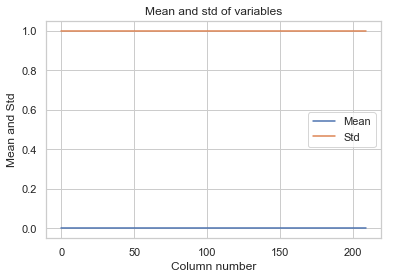

In [8]:

df_mean_std2 = pd.DataFrame(data = [df.describe().iloc[1,:p], df.describe().iloc[2,:p]], columns = df.columns , index=["Mean","Std"])
df_mean_std2.T.plot()
plt.title('Mean and std of variables')
plt.xlabel('Column number')
plt.ylabel('Mean and Std')
plt.show()

As we can see, all the means and std of the explaining variables are close to 0 and 1. It means the dataset have been centered.
Concerning the variable to explain, it is not the case, std is 77.09 and mean 152.13

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AE9E1F75C0>,
      dtype=object)

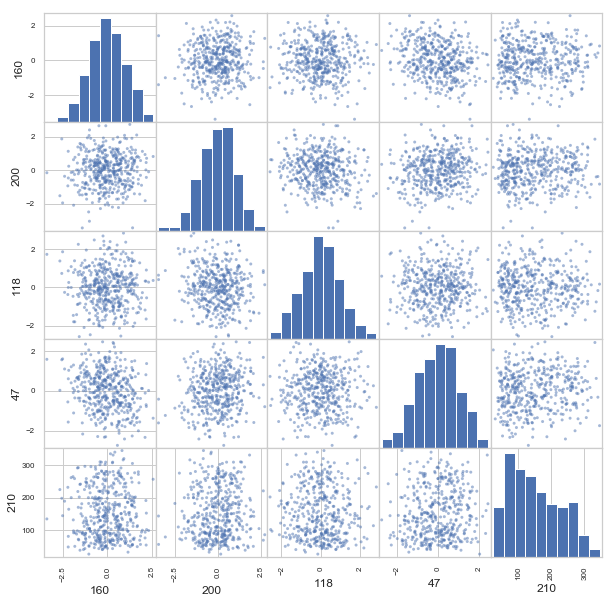

In [9]:
extract = random.sample(range(p),4) + [p]
plt_df = df[extract]
scatter_matrix(plt_df,   
               figsize=(10, 10)) 
# scroll to see the graph

## Splitting the data

We create a train and test set

In [10]:
def split_data(X1,Y1,seed_data):
    return train_test_split(X1,Y1, test_size=0.2, random_state=seed_data)

trainData, testData = train_test_split(df, test_size=0.2, random_state=seed)
print("Size of the training set (contains Y thats why there is 211)", trainData.shape)
print("Size of the testing set (contains Y thats why there is 211)", testData.shape)

X = df.iloc[:,:p]
Y = df.iloc[:,p]

# We create the training and testing set
X_train, X_test, Y_train, Y_test = split_data(X,Y,seed)
print("Size of X_train", X_train.shape)
print("Size of X_test", X_test.shape)
print("Size of Y_train", Y_train.shape)
print("Size of Y_test", Y_test.shape)

Size of the training set (contains Y thats why there is 211) (353, 211)
Size of the testing set (contains Y thats why there is 211) (89, 211)
Size of X_train (353, 210)
Size of X_test (89, 210)
Size of Y_train (353,)
Size of Y_test (89,)


## Correlation matrix

We create a correlation matrix and prepare our PCA

In [11]:
# Computation and print of the correlation matrix
cov_matrix = X_train.cov() 
#print("Covariance matrix : ", cov_matrix)

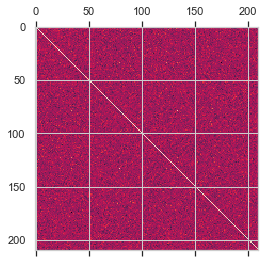

In [12]:
# Graphical view of the correlation matrix
plt.matshow(X_train.iloc[:,:].cov()) #précédament corr

In [13]:
# We compute the eigenvalues and eigenvectors
eigenValues, eigenVectors = np.linalg.eigh(cov_matrix)
#eigenValues

# We sort the values
idx = eigenValues.argsort()[::-1]
sort_eig = eigenValues[idx]    
sort_vect = eigenVectors[:, idx]

Text(0,0.5,'Eigenvalue')

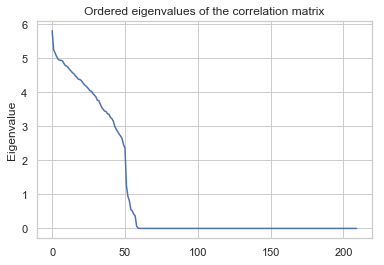

In [14]:

# We plot the eigenvalues ordered
plt.figure()
#sorted_eig = pd.Series(eigenValues).sort_values(ascending=False).reset_index()
sorted_eig = pd.Series(sort_eig)
graph2 = sorted_eig.plot()
graph2.set_title("Ordered eigenvalues of the correlation matrix" )
graph2.set_ylabel("Eigenvalue" )

We ordered the eigenvalues with a decreasing orders, so the first values will be the one with the bigger importance. Bigger the eigenvalue is, bigger is its importance regarding the gloal variance of the dataset. The more of those values we take, the less they are important (because they become really close to 0). We can see graphically that after the 60th eigenvalue, the other one are almost negligable. That's why taking the first 60 values seems a good choice since they are the most important ones .

## PCA before OLS


We apply the "PCA before OLS" which consist of doing an ACP before a regression

In [15]:
# We compute the PCA manually then use the OLS
U_pca = sort_vect[:,:60]
X_train_pca_manual = X_train.dot(U_pca)
X_test_pca_manual = X_test.dot(U_pca)
X_train_pca_manual.head()

# We create our scikit learn model
skl_lm_manual = linear_model.LinearRegression(fit_intercept=True)
skl_lm_manual.fit(X_train_pca_manual, Y_train)
#y_pred_scikit = skl_lm.predict([X2_new])

print("Intercept of linear regression with PCA (manual): " ,skl_lm_manual.intercept_)
print("Coefficients: \n", skl_lm_manual.coef_)
score_pca_manual = skl_lm_manual.score(X_test_pca_manual, Y_test)
print("Score: \n", score_pca_manual)

Intercept of linear regression with PCA (manual):  150.58305697170545
Coefficients: 
 [ 12.13667422   1.4346188    1.70061845   6.73701502  -1.2477811
  -1.38524777   5.54852982   1.89714488   0.38251023   2.22768928
  -1.54617802   1.23064985  -4.02481958   0.3673044   -3.79787859
  -2.58310864  -1.39905777  -0.1346773    2.84217261   3.20957695
   0.20887289   1.04154168   0.57330895  -1.71139078  -1.32481335
  -5.25712701  -3.34787259  -4.05603714  -2.25330855  -0.40971134
   2.97598745  -2.45975391  -0.7693707   -0.87892751  -5.1714994
  -4.33969909  -0.55653734  -3.50873229   2.46795421   5.60207875
   2.80583887   2.95483355   2.92910344  -0.50487874   6.74061918
   4.07243399   5.73638281   0.51460293  -3.23427523  -6.31803507
   6.98855244 -10.38603853  12.18451965 -24.65159351   1.6992544
   5.75866895  10.06767998  -0.56656988  -8.61781368 -24.40405448]
Score: 
 0.2984760669257357


In [16]:

# We compute the PCA with sklearn then use the OLS

# Dimension reduction with PCA

# We create the model
pca = PCA(n_components=60)

# We train it on the train data
model_pca = pca.fit(X_train)

# We transform the data acording to the model (keeping 60 significativ variables)
X_train_pca = pd.DataFrame(model_pca.transform(X_train))
X_test_pca = pd.DataFrame(model_pca.transform(X_test))

# We create our scikit learn model
skl_lm = linear_model.LinearRegression(fit_intercept=True)
skl_lm.fit(X_train_pca, Y_train)

print("Intercept of linear regression with PCA (sklearn): " ,skl_lm.intercept_)
print("Coefficients: \n", skl_lm.coef_)
score_pca_sklearn = skl_lm.score(X_test_pca, Y_test)
print("Score: \n", score_pca_sklearn)

Intercept of linear regression with PCA (sklearn):  153.37677053824362
Coefficients: 
 [-12.13667422   1.4346188    1.70061845   6.73701502   1.2477811
   1.38524777  -5.54852982   1.89714488   0.38251023  -2.22768928
  -1.54617802   1.23064985  -4.02481958  -0.3673044    3.79787859
  -2.58310864  -1.39905777   0.1346773    2.84217261  -3.20957695
   0.20887289   1.04154168   0.57330895   1.71139078   1.32481335
   5.25712701   3.34787259   4.05603714   2.25330855   0.40971134
   2.97598745  -2.45975391   0.7693707    0.87892751  -5.1714994
   4.33969909   0.55653734   3.50873229   2.46795421  -5.60207875
  -2.80583887  -2.95483355   2.92910344   0.50487874  -6.74061918
  -4.07243399  -5.73638281   0.51460293  -3.23427523  -6.31803507
  -6.98855244 -10.38603853 -12.18451965  24.65159351  -1.6992544
   5.75866895  10.06767998   0.56656988   8.61781368 -24.40405448]
Score: 
 0.298476066925736


Text(0.5,1,'PCA before OLS : Theta values')

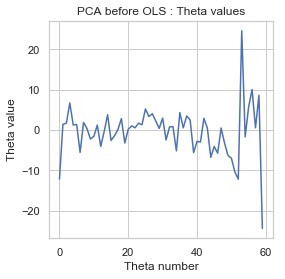

In [17]:
# We plot the theta values
plt.figure(figsize=(4,4))
plt.plot([x for x in range(len(skl_lm.coef_))], pd.Series(skl_lm.coef_))
plt.xlabel("Theta number")
plt.ylabel("Theta value")
plt.title("PCA before OLS : Theta values")


In [18]:
## Simple Lienear model without PCA

# We create our scikit learn model
skl_lm2 = linear_model.LinearRegression(fit_intercept=True)
skl_lm2.fit(X_train, Y_train)

print("Intercept of linear regression with PCA : " ,skl_lm2.intercept_)
print("Coefficients: \n", skl_lm2.coef_)
score_OLS_only = skl_lm2.score(X_test, Y_test)
print("Score: \n", score_OLS_only)

Intercept of linear regression with PCA :  152.65020803824362
Coefficients: 
 [-3.84035520e+14  2.47974574e+15 -2.02915187e+15 -1.33519830e+15
  7.65741026e+14  2.65643164e+15 -3.00471876e+14  8.27471799e+14
 -1.82401114e+15 -1.72909908e+15  4.72527613e+14 -1.51491451e+14
  1.39299864e+15 -1.60165968e+15 -1.34530600e+15  1.07013006e+15
 -1.23650894e+14 -2.34395835e+15  3.17094649e+15 -2.38776558e+15
 -2.87161472e+15 -1.78563294e+15  3.04761681e+15  7.25000000e+00
 -2.10317695e+15  4.40864213e+15 -1.59153973e+15  3.06021483e+15
  9.76123635e+14  2.63771772e+15  1.17226111e+14 -2.04691049e+15
  5.18861995e+13 -1.88137694e+14  1.50937500e+01  8.73999645e+14
  8.83913618e+14 -2.05716853e+15 -2.37162697e+15 -5.66625319e+14
 -1.45222348e+15  2.82392140e+15 -1.97570106e+14 -3.27429716e+14
 -8.28676773e+14 -3.87963460e+14 -1.49720892e+15  3.31613367e+15
 -1.08147798e+15 -3.15354951e+14  3.75520319e+14 -8.53382410e+14
  5.47425082e+15 -1.14737426e+15 -1.81638928e+15 -4.61961215e+14
  1.68220525

Text(0.5,1,'PCA before OLS : Theta values')

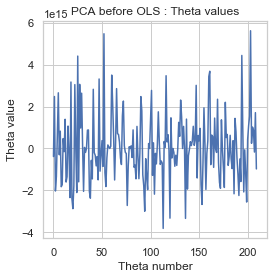

In [19]:
# We plot the theta values
plt.figure(figsize=(4,4))
plt.plot([x for x in range(len(skl_lm2.coef_))], pd.Series(skl_lm2.coef_))
plt.xlabel("Theta number")
plt.ylabel("Theta value")
plt.title("PCA before OLS : Theta values")


## Comparing the two regression

In [20]:
print("Intercept for model with PCA (sklearn): ", skl_lm.intercept_)
print("Intercept for model with PCA (manual): ", skl_lm_manual.intercept_)
print("Intercept for model without PCA : ", skl_lm2.intercept_)
print("Y mean on train set : ", Y_train.mean())

Intercept for model with PCA (sklearn):  153.37677053824362
Intercept for model with PCA (manual):  150.58305697170545
Intercept for model without PCA :  152.65020803824362
Y mean on train set :  153.37677053824362


In [21]:
print("Difference between the two intercepts (pca sklearn): ", skl_lm.intercept_ - skl_lm2.intercept_ )
print("Difference between the two intercepts (pca manual): ", skl_lm_manual.intercept_ - skl_lm2.intercept_ )
print("Difference between the two scores (pca manual): ", score_pca_manual - score_OLS_only )
print("Difference between the two scores (pca sklearn): ", score_pca_sklearn - score_OLS_only )

Difference between the two intercepts (pca sklearn):  0.7265625
Difference between the two intercepts (pca manual):  -2.067151066538173
Difference between the two scores (pca manual):  0.1301595695777482
Difference between the two scores (pca sklearn):  0.13015956957774855


So we did 2 linear models, one using PCA before and one on the raw data. As we can see the two models gives close results ( intercept almost the same). It means choosing 60 variables explains almost as well the dataset as the full dataset does. We improved our score using PCA (for sklearn)

In [22]:
# We rescale the data
sc = StandardScaler()
model_pca_centered = sc.fit(X_train_pca)
X_train_pca_centered = model_pca_centered.transform(X_train_pca)
X_test_pca_centered = model_pca_centered.transform(X_test_pca)

# We create our scikit learn model
skl_lm3 = linear_model.LinearRegression(fit_intercept=True)
skl_lm3.fit(X_train_pca_centered, Y_train)

score_pca_centered = skl_lm3.score(X_test_pca_centered, Y_test)

print("Intercept of linear regression with PCA and variable centered: " ,skl_lm3.intercept_)
print("Difference between Y train mean and the recentered PCA model : ", skl_lm3.intercept_ - Y_train.mean())
print("Score of the PCA(centered)-OLS : ",score_pca_centered)

Intercept of linear regression with PCA and variable centered:  153.37677053824362
Difference between Y train mean and the recentered PCA model :  0.0
Score of the PCA(centered)-OLS :  0.298476066925736


We have equality between centered model with PCA and Y mean

## Ploting the residuals

In [23]:
# Computation of the résiduals
y_hat_pca = skl_lm.intercept_ + X_test_pca @ skl_lm.coef_
res_pca = pd.Series(np.subtract(Y_test,y_hat_pca)).reset_index()

y_hat = skl_lm2.intercept_ + X_test @ skl_lm2.coef_
res = pd.Series(np.subtract(Y_test,y_hat)).reset_index()

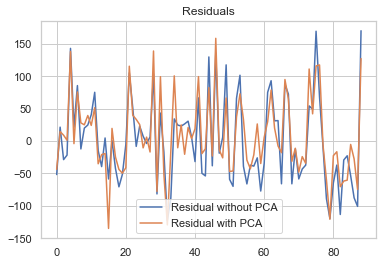

In [24]:

# We plot the residuals
df_residuals = pd.DataFrame(data = [res[210], res_pca[210]], index=["Residual without PCA","Residual with PCA"])
df_residuals.T.plot()
plt.title('Residuals')
#plt.xlabel('Column number')
#plt.ylabel('Mean and Std')
plt.show()

As we can see, there is less residuals using PCA

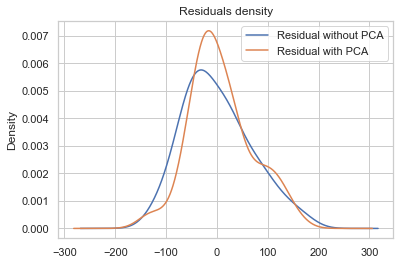

In [25]:
# we plot the density
df_residuals.T.plot.kde()
plt.title('Residuals density')
plt.show()

In [26]:
# Computation of the determination coefficient
score_pca_manual = skl_lm_manual.score(X_test_pca_manual, Y_test)
score_pca_sklearn = skl_lm.score(X_test_pca, Y_test)
score_OLS_only = skl_lm2.score(X_test, Y_test)
print("Score with PCA (manual): \n", score_pca_manual)
print("Score with PCA (sklearn): \n", score_pca_sklearn)
print("Score without PCA : \n", score_OLS_only)

Score with PCA (manual): 
 0.2984760669257357
Score with PCA (sklearn): 
 0.298476066925736
Score without PCA : 
 0.16831649734798748


In [27]:


risk_pca = mean_squared_error(Y_test, y_hat_pca)
risk = mean_squared_error(Y_test, y_hat)

print("Prediction risk with PCA : ", risk_pca)
print("Prediction risk without PCA : ", risk)


Prediction risk with PCA :  3738.400226560899
Prediction risk without PCA :  4432.016711270357


## Forward selection

In [28]:

# We implement the forward selection algorithm

# We create our X forward
X_fw = np.column_stack( (np.ones( (X_train.shape[0], 1 )), X_train )) 

# We set our size
P = X_fw.shape[1]
N = X_fw.shape[0]

# We prepare the list we will need
tstat = np.zeros((P,P))
pval_list = np.zeros(P)
pval = np.zeros((P,P))
residuals = Y_train
X_selected = []
X_remaining = list(range(P))

# We fit our linear model
regression = linear_model.LinearRegression(fit_intercept = False)


for k in range(P): 
    residuals_list = np.zeros((P,N))

    for i in X_remaining:
        # We select the column i of X
        X_col = X_fw [:,[i]]
        regression.fit(X_col , residuals)
        
        # We compute the residuals
        residuals_list [i,:] = regression.predict(X_col) - residuals
        # We computesigma squared
        sigma_squared = np.sum (residuals_list [i,:] ** 2) / np.sum( X_fw [:,[i]] ** 2 ) 
        # We use both to have the tstat and pvalue
        tstat[k,i] = np.sqrt(N) * np.abs(regression.coef_) / (np.sqrt( sigma_squared )) 
        pval[k,i] =   2 * (1 - stats.norm.cdf(tstat[k,i]))

    # We construct the list of elements
    tstat_max = np.argmax(tstat[k,:])
    residuals = residuals_list[tstat_max,:]
    
    X_selected.append(tstat_max)
    pval_list [k] = pval[k,tstat_max]
    
    X_remaining = np.setdiff1d(X_remaining,X_selected)



In [29]:
# We print the result
print("The X values ordered are: (with column 0 being the intercept, and 1 the first X value)")
display(pd.DataFrame(X_selected[0:]).T) # We could remove the intercept column

The X values ordered are: (with column 0 being the intercept, and 1 the first X value)


,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,0,59,124,85,173,44,188,111,134,209,...,161,36,2,109,50,196,72,194,183,77


We decide to stop when the p value is greater than 0.1

In [30]:

# We implement the forward selection algorithm

# We create our X forward
X_fw2 = np.column_stack( (np.ones( (X_train.shape[0], 1 )), X_train )) 

# We set our size
P = X_fw2.shape[1]
N = X_fw2.shape[0]

# We prepare the list we will need
tstat2 = np.zeros((P,P))
pval_list2 = np.zeros(P)
pval2 = np.zeros((P,P))
residuals2 = Y_train
X_selected2 = []
X_selected2_minus1 = [] # this list is to have real indices for X not with the intercept
X_remaining2 = list(range(P))
last_value = 0

# We fit our linear model
regression2 = linear_model.LinearRegression(fit_intercept = False)

k = 0
while last_value< 0.1: 
    #print("k ", k)
    residuals_list2 = np.zeros((P,N))

    for i in X_remaining2:
        # We select the column i of X
        X_col2 = X_fw2 [:,[i]]
        regression2.fit(X_col2 , residuals2)
        
        # We compute the residuals
        residuals_list2 [i,:] = regression2.predict(X_col2) - residuals2
        # We computesigma squared
        sigma_squared2 = np.sum (residuals_list2 [i,:] ** 2) / np.sum( X_fw2 [:,[i]] ** 2 ) 
        # We use both to have the tstat and pvalue
        tstat2[k,i] = np.sqrt(N) * np.abs(regression2.coef_) / (np.sqrt( sigma_squared2 )) 
        pval2[k,i] =   2 * (1 - stats.norm.cdf(tstat2[k,i]))

    # We construct the list of elements
    tstat_max2 = np.argmax(tstat2[k,:])
    residuals2 = residuals_list2[tstat_max2,:]
    
    X_selected2.append(tstat_max2)
    X_selected2_minus1.append(tstat_max2-1)
    pval_list2 [k] = pval2[k,tstat_max2]
    last_value = pval2[k,tstat_max2]
    
    X_remaining2 = np.setdiff1d(X_remaining2,X_selected2)
    k = k+1



We print the first 4 because the first step select the intercept, so if we want only the others we print the next 3


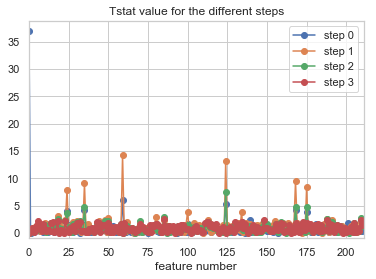

In [31]:
print("We print the first 4 because the first step select the intercept, so if we want only the others we print the next 3")
fig = plt.figure()
for k in range(4): 
    plt.plot(np.arange(P),tstat[k,:], '-o',label = "step %s" % k)
    plt.axis(xmin = 0,xmax = 211,ymin = -1)
plt.legend(loc=1)
plt.xlabel("feature number")
plt.title("Tstat value for the different steps")
plt.show()


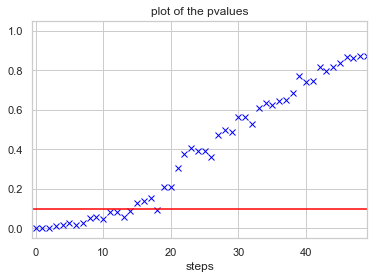

In [32]:
fig2 = plt.figure() 
plt.plot(np.arange(P),pval_list, 'x', color="blue")
plt.plot([-0.5,49],[.1,.1],color = "red" )
plt.axis(xmin = -.5,xmax = 49,ymin = -.05) # We only want to print pvalues
plt.title("plot of the pvalues")
plt.xlabel("steps")
plt.show()


In [33]:
# We print the result
print("The X values ordered are: (with column 0 being the intercept, and 1 the first X value)")
display(pd.DataFrame(X_selected2[0:]).T) # We could remove the intercept column
print("number of element selected : ", len(X_selected2[0:]))

print("If we want the correct indices : (we do not put the intercept here)\n", X_selected2_minus1[1:])

The X values ordered are: (with column 0 being the intercept, and 1 the first X value)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,59,124,85,173,44,188,111,134,209,15,35,160,148,136,42


number of element selected :  16
If we want the correct indices : (we do not put the intercept here)
 [58, 123, 84, 172, 43, 187, 110, 133, 208, 14, 34, 159, 147, 135, 41]


## Applying OLS on the selected variables

In [34]:
# We slect our variables
X_to_select = pd.DataFrame(X_fw2)
X_train_selected_fw = X_train.iloc[:,X_selected2_minus1[1:]] # we do not take the intercept
X_test_selected_fw = X_test.iloc[:,X_selected2_minus1[1:]] # we do not take the intercept


In [35]:
# We apply the OlS on the selected variables
model_selected = linear_model.LinearRegression(fit_intercept=True).fit(X_train_selected_fw,Y_train)
theta_selected = model_selected.coef_

In [36]:
print("Theta selected \n", theta_selected)

Theta selected 
 [ 30.96966783  27.05489718  -8.00791039  -5.46551289  -6.70676867
  -6.50329009   7.05626883 -11.1184131    5.76899893  -7.69092618
  14.38552484  -8.13406567  -6.79873991  -7.37395272   4.18249537]


In [37]:
# Calculer le risque de prédiction en comparer
y_hat_fw = model_selected.intercept_ + X_test_selected_fw @ theta_selected
risk_fw = mean_squared_error(Y_test, y_hat_fw)
print("Prediction risk with forward selectionn : ", risk_fw)

Prediction risk with forward selectionn :  3958.5226104168078


In [38]:
score_fw = model_selected.score(X_test_selected_fw, Y_test)
print("Score forward : ", score_fw)

Score forward :  0.25716932844890417


## Cross validation

In [39]:
def split_data_Half(X1,Y1,seed_data):
    return train_test_split(X1,Y1, test_size=0.5, random_state=seed_data)
# We split our data in half
X_half1,X_half2,Y_half1,Y_half2 = split_data_Half(X_train,Y_train,seed)

# We split it again in two
X_fold1,X_fold2,Y_fold1,Y_fold2 = split_data_Half(X_half1,Y_half1,seed)
X_fold3,X_fold4,Y_fold3,Y_fold4 = split_data_Half(X_half2,Y_half2,seed)

In [40]:
ind_choosen1 = pd.DataFrame(X_fold1.index)
ind_choosen2 = pd.DataFrame(X_fold2.index)
ind_choosen3 = pd.DataFrame(X_fold3.index)
ind_choosen4 = pd.DataFrame(X_fold4.index)

print("Indexes choosen for Fold1 :")
display(ind_choosen1.T)
print("Indexes choosen for Fold2 :")
display(ind_choosen2.T)
print("Indexes choosen for Fold3 :")
display(ind_choosen3.T)
print("Indexes choosen for Fold4 :")
display(ind_choosen4.T)

Indexes choosen for Fold1 :


,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,394,313,210,124,268,144,14,312,104,142,...,265,211,76,427,305,98,127,50,306,60


Indexes choosen for Fold2 :


,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,80,376,143,130,281,215,239,41,270,71,...,344,272,25,352,153,157,369,116,244,259


Indexes choosen for Fold3 :


,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,240,241,387,378,400,414,134,117,320,297,...,13,355,44,205,151,261,52,92,282,137


Indexes choosen for Fold4 :


,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,227,300,342,103,36,115,269,432,26,191,...,395,413,341,113,223,336,410,308,74,428


## Regularisating with ridge

We create 4 folds

In [41]:
folds = [
    X_fold1.index.tolist(),
    X_fold2.index.tolist(),
    X_fold3.index.tolist(),
    X_fold4.index.tolist()]


In [42]:
#ridge_coefs = np.linspace(0.01,100,40)
ridge_coefs = [0.0001,0.0003,0.0006,
        0.001,0.003,0.006,
        0.01,0.03,0.06,
        0.1,0.3,0.6,
        1,3,6,
        10,30,60,
        100,300,600,
        1000,3000,6000
       ]
rp_means = []

for ridge_coef in ridge_coefs:
    prediction_risk = []

    for fold in folds:
        rlm = linear_model.Ridge(alpha=ridge_coef)
        RX_test = X_train.loc[fold]
        RX_train = X_train[~X_train.index.isin(fold)]
        
        ridge_model= rlm.fit(RX_train, Y_train.loc[~Y_train.index.isin(fold)])
        ridge_predict = ridge_model.predict(RX_test)

        prediction_risk.append(mean_squared_error(Y_train.loc[fold], ridge_predict))

    rp_means.append(np.mean(prediction_risk))

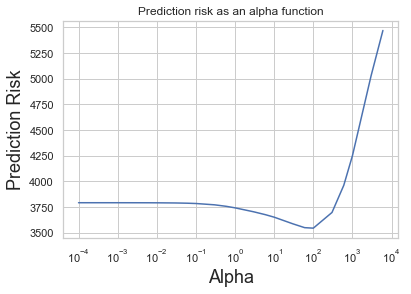

In [43]:
plt.figure()
plt.plot(ridge_coefs, rp_means)
plt.xscale("log")
plt.title("Prediction risk as an alpha function")
plt.xlabel('Alpha', fontsize=18)
plt.ylabel('Prediction Risk', fontsize=18)
plt.show()

In [44]:
print("Optimal prediction risk (minimal) : ", pd.Series(rp_means).min())
print("Optimal param :", ridge_coefs[pd.Series(rp_means).idxmin()])

Optimal prediction risk (minimal) :  3543.2427415717875
Optimal param : 100


## Regularisating with Lasso

In [45]:
model_lasso_cv = linear_model.LassoCV(fit_intercept=True, cv=4, copy_X=True).fit(X_train,Y_train) #normalize=True

In [46]:
theta_lasso_cv = model_lasso_cv.coef_
intercept_lasso_cv = model_lasso_cv.intercept_

In [47]:
y_hat_lasso_cv = intercept_lasso_cv + X_test @ theta_lasso_cv
risk_lasso_cv = mean_squared_error(Y_test, y_hat_lasso_cv)

print("Prediction risk without PCA : ", risk)
print("Prediction risk with PCA : ", risk_pca)
print("Prediction risk with forward selection: ", risk_fw)
print("Prediction risk with lasso CV : ", risk_lasso_cv)

Prediction risk without PCA :  4432.016711270357
Prediction risk with PCA :  3738.400226560899
Prediction risk with forward selection:  3958.5226104168078
Prediction risk with lasso CV :  3130.8112331649713


As we can see the prediction risk diminish when we use the lasso method

Least square lasso method

In [48]:
nonzeroind = np.nonzero(theta_lasso_cv)[0]
print ("The number of theta different to zero, or variable selected by lasso is: ", len(nonzeroind))
print("The indices selected are : ", nonzeroind)

The number of theta different to zero, or variable selected by lasso is:  19
The indices selected are :  [  8  17  22  23  43  58  84 110 112 123 129 135 147 159 167 174 187 208
 209]


In [49]:
# We select the features accoding to the lasso results
X_lasso_selected = X_train.iloc[:,nonzeroind]
X_test_lasso_selected = X_test.iloc[:,nonzeroind]

# We create our OLS model
model_linear_lasso_cv = linear_model.LinearRegression(fit_intercept=True).fit(X_lasso_selected,Y_train)
score_lasso = model_linear_lasso_cv.score(X_test_lasso_selected, Y_test)

In [50]:

print("New parametters with lasso before OLS :")
print("Intercept Lasso", model_linear_lasso_cv.intercept_)
print("CoefficientLasso", model_linear_lasso_cv.coef_)


New parametters with lasso before OLS :
Intercept Lasso 151.2471604390093
CoefficientLasso [  5.49741748  -8.56201586   1.39623604   3.47778174  -2.65512717
  23.98440239  -1.75307316   8.15188228   2.52851238  21.19096734
  -3.40645058 -11.60155346  -7.69524268  -6.71582799  12.356183
 -15.1579525   -4.80794908   6.28798491  -3.32343727]


In [51]:
print("Difference between Y train mean and the PCA model (sklearn): ", skl_lm.intercept_ - Y_train.mean())
print("Difference between Y train mean and the PCA model (manual): ", skl_lm_manual.intercept_ - Y_train.mean())
print("Difference between Y train mean and the model without PCA : ", skl_lm2.intercept_ - Y_train.mean())
print("Difference between Y train mean and the recentered PCA model : ", skl_lm3.intercept_ - Y_train.mean())
print("Difference between Y train mean and the forward selection model : ", model_selected.intercept_ - Y_train.mean())
print("Difference between Y train mean and the lasso-OLS model : ", model_linear_lasso_cv.intercept_ - Y_train.mean())

Difference between Y train mean and the PCA model (sklearn):  0.0
Difference between Y train mean and the PCA model (manual):  -2.793713566538173
Difference between Y train mean and the model without PCA :  -0.7265625
Difference between Y train mean and the recentered PCA model :  0.0
Difference between Y train mean and the forward selection model :  -2.3835603535521557
Difference between Y train mean and the lasso-OLS model :  -2.129610099234327


In [52]:
print("Score the PCA-OLS model (manual): ", score_pca_manual)
print("Score the PCA-OLS model (sklearn): ", score_pca_sklearn)
print("Score the OLS model : ", score_OLS_only)
print("Score the PCA(centered)-OLS model : ", score_pca_centered)
print("Score the forward-OLS model: ", score_fw)
print("Score the Lasso-OLS : ", score_lasso)


Score the PCA-OLS model (manual):  0.2984760669257357
Score the PCA-OLS model (sklearn):  0.298476066925736
Score the OLS model :  0.16831649734798748
Score the PCA(centered)-OLS model :  0.298476066925736
Score the forward-OLS model:  0.25716932844890417
Score the Lasso-OLS :  0.2997888710055705


## Non linear aproach

In [95]:


###### We try a first method using pylonomial function :

poly = PolynomialFeatures(degree=3) # We try a fird degree polynom to try non linearity

# We use the lasso selected variables
X_train_non_linear = poly.fit_transform(X_lasso_selected)
X_test_non_linear = poly.fit_transform(X_test_lasso_selected)

# We create our scikit learn model
skl_lm_non_linear = linear_model.LinearRegression(fit_intercept=True)
skl_lm_non_linear.fit(X_train_non_linear, Y_train)

print("**** Non linear with polynom ****")

#We compute the score
score_non_linear = skl_lm_non_linear.score(X_test_non_linear, Y_test)

print("Score: \n", score_non_linear)

# We compute the risk
y_hat_non_linear = skl_lm_non_linear.intercept_ + X_test_non_linear @ skl_lm_non_linear.coef_
risk_non_linear = mean_squared_error(Y_test, y_hat_non_linear)

print("The score is not really good and the intercept is close but not as much as the previous one")
print("Risk of the new method : ",risk_non_linear,". As we can see the risk is higher than before ")



**** Non linear with polynom ****
Score: 
 0.04344557640840463
The score is not really good and the intercept is close but not as much as the previous one
Risk of the new method :  5097.450144290506 . As we can see the risk is higher than before 


In [99]:

###### We try with cross validation and SVR with a non linear function  :
svr = SVR()

paramGridSvr = {'degree': [3,4,5,6], 'kernel': ["poly"]}


cv = GridSearchCV(estimator = svr, param_grid = paramGridSvr, cv = 4)


#Fit cross-validation model
cvModel = cv.fit(X_lasso_selected,Y_train)

print("**** SVR polynomial method ****")
print("Grid search best parameters from the 100% of the training set:")
print(cvModel.best_params_)
print("Best score from the training set:")
print(cvModel.best_score_)

best_grid = cvModel.best_estimator_

y_hat_test_cv = best_grid.predict(X_test_lasso_selected)

score_non_linear2 = cvModel.score(X_test_lasso_selected, Y_test)
print("Score of the non linear method (on test): \n", score_non_linear2)

risk_non_linear2 = mean_squared_error(Y_test, y_hat_test_cv)
print("Risk of the new method (SVR polynomial): ",risk_non_linear2,". As we can see the risk is higher than before ")
print("We can see here by changing the kernel parameter to linear that the linear model seem more adapted")


**** SVR polynomial method ****
Grid search best parameters from the 100% of the training set:
{'degree': 3, 'kernel': 'poly'}
Best score from the training set:
0.05547211895634937
Score of the non linear method (on test): 
 0.07310547930443123
Risk of the new method (SVR polynomial):  4939.393401706725 . As we can see the risk is higher than before 
We can see here by changing the kernel parameter to linear that the linear model seem more adapted
